In [ ]:
import numpy as np
from jesse import helpers, research

_, trading_1m = research.get_candles(
    "Binance Spot",
    "BTC-USDT",
    "1m",
    helpers.date_to_timestamp("2020-01-01"),
    helpers.date_to_timestamp("2025-04-20"),
    warmup_candles_num=0,
    caching=False,
    is_for_jesse=False,
)

trading_1m.shape


In [ ]:
np.save("data/btc_1m.npy", trading_1m)

In [ ]:
import numpy as np

candles = np.load("data/btc_1m.npy")
candles.shape

In [ ]:
# import os

# import pandas as pd
# from jesse.utils import numpy_candles_to_dataframe
# from pandarallel import pandarallel

# pandarallel.initialize(nb_workers=os.cpu_count() - 1, progress_bar=True)

# from custom_indicators.toolbox.entropy.apen_sampen import sample_entropy
# from custom_indicators.volitility_indicator.yang_zhang import yang_zhang_volatility

# df = numpy_candles_to_dataframe(candles)
# df["vol_150"] = yang_zhang_volatility(candles, period=150, sequential=True)
# df["vol_360"] = yang_zhang_volatility(candles, period=360, sequential=True)
# df["window"] = 150
# df["window_on_vol"] = df["window"] * df["vol_360"] / df["vol_150"]

# c_arr = df["close"].to_numpy()
# lag_arr = df["window_on_vol"].to_numpy()
# log_ret = [
#     np.log(c_arr[i] / c_arr[-round(lag) + i : i]) if np.isfinite(lag) else np.nan
#     for i, lag in zip(range(len(lag_arr)), lag_arr)
# ]
# df["log_ret"] = pd.Series(log_ret, index=df.index)
# df["samp_en"] = df["log_ret"].parallel_apply(
#     lambda x: sample_entropy(x) if isinstance(x, np.ndarray) else np.nan
# )

# df

In [1]:
import os

import numpy as np
import optuna
from mpire import WorkerPool
from scipy import stats

from custom_indicators.toolbox.bar.build import build_bar_by_cumsum
from custom_indicators.toolbox.entropy.apen_sampen import sample_entropy_numba
from custom_indicators.volitility_indicator.yang_zhang import yang_zhang_volatility


def objective(trial: optuna.Trial) -> float:
    candles = np.load("data/btc_1m.npy")
    vol_t_window = trial.suggest_int("vol_t", 30, 360)
    vol_ref_window = trial.suggest_int("vol_ref", vol_t_window, 60 * 24 * 7)
    vol_t = yang_zhang_volatility(candles, period=vol_t_window, sequential=True)
    vol_ref = yang_zhang_volatility(candles, period=vol_ref_window, sequential=True)

    window = trial.suggest_int("window", 30, 360)
    window_on_vol = window * vol_ref / (vol_t + 1e-10)
    window_on_vol = np.clip(window_on_vol, 30, 60 * 24 * 7)
    log_ret_list = []
    for idx, w_on_vol in enumerate(window_on_vol):
        if np.isfinite(w_on_vol):
            w_on_vol = round(w_on_vol)
            if idx - w_on_vol >= 0:
                log_ret_list.append(
                    np.log(candles[idx, 2] / candles[idx - w_on_vol : idx, 2])
                )
    with WorkerPool(n_jobs=os.cpu_count() - 1) as pool:
        entropy_array = pool.map(sample_entropy_numba, log_ret_list)

    len_gap = len(candles) - len(entropy_array)
    candles = candles[len_gap:]
    window_on_vol = np.round(window_on_vol[len_gap:])
    is_div_window = trial.suggest_categorical("is_div_window", [True, False])
    if is_div_window:
        entropy_array = entropy_array / window_on_vol

    threshold_min = np.sum(entropy_array) / (len(candles) // 60)
    threshold_max = np.sum(entropy_array) / (len(candles) // 360)
    entropy_threshold = trial.suggest_float(
        "entropy_threshold", threshold_min, threshold_max
    )
    merged_bar = build_bar_by_cumsum(candles, entropy_array, entropy_threshold)
    if len(merged_bar) < len(candles) // 360:
        return 500
    close_arr = merged_bar[:, 2]
    ret = np.log(close_arr[1:] / close_arr[:-1])
    standard = (ret - ret.mean()) / ret.std()
    kurtosis = stats.kurtosis(standard, axis=None, fisher=False, nan_policy="omit")
    return kurtosis


TRIALS = 1000

study = optuna.create_study(
    direction="minimize",
    pruner=optuna.pruners.HyperbandPruner(),
    sampler=optuna.samplers.TPESampler(n_startup_trials=50),
)
study.optimize(objective, n_trials=TRIALS, n_jobs=1)

[I 2025-05-20 00:00:52,412] A new study created in memory with name: no-name-ef344287-48ec-4cee-80c6-a3fe4e2d4bd4
[I 2025-05-20 00:03:24,521] Trial 0 finished with value: 17.421301096285884 and parameters: {'vol_t': 104, 'vol_ref': 9511, 'window': 291, 'is_div_window': False, 'entropy_threshold': 9.598402044547068}. Best is trial 0 with value: 17.421301096285884.
[I 2025-05-20 00:05:46,660] Trial 1 finished with value: 27.399201412721485 and parameters: {'vol_t': 313, 'vol_ref': 5513, 'window': 351, 'is_div_window': False, 'entropy_threshold': 8.385859547160791}. Best is trial 0 with value: 17.421301096285884.
[I 2025-05-20 00:07:45,944] Trial 2 finished with value: 33.855328225919195 and parameters: {'vol_t': 181, 'vol_ref': 3427, 'window': 300, 'is_div_window': True, 'entropy_threshold': 0.018679827442502926}. Best is trial 0 with value: 17.421301096285884.
[I 2025-05-20 00:09:01,927] Trial 3 finished with value: 35.46704904606226 and parameters: {'vol_t': 296, 'vol_ref': 8701, 'wind

In [2]:
study.best_params

{'vol_t': 55,
 'vol_ref': 9424,
 'window': 52,
 'is_div_window': False,
 'entropy_threshold': 53.37804908688859}

In [ ]:
"""
{
 'vol_t': 161,
 'vol_ref': 1137,
 'window': 133,
 'is_div_window': False,
 'entropy_threshold': 28.081028495804635
}

{
 'vol_t': 55,
 'vol_ref': 9424,
 'window': 52,
 'is_div_window': False,
 'entropy_threshold': 53.37804908688859
}
"""

In [1]:
import numpy as np

candles = np.load("data/btc_1m.npy")
vol_t_window = 161
vol_ref_window = 1137
window = 133
entropy_threshold = 28.081028495804635
vol_t = yang_zhang_volatility(candles, period=vol_t_window, sequential=True)
vol_ref = yang_zhang_volatility(candles, period=vol_ref_window, sequential=True)

window_on_vol = window * vol_ref / (vol_t + 1e-10)
window_on_vol = np.clip(window_on_vol, 30, 60 * 24)
log_ret_list = []
for idx, w_on_vol in enumerate(window_on_vol):
    if np.isfinite(w_on_vol):
        w_on_vol = round(w_on_vol)
        if idx - w_on_vol >= 0:
            log_ret_list.append(
                np.log(candles[idx, 2] / candles[idx - w_on_vol : idx, 2])
            )
with WorkerPool(n_jobs=os.cpu_count() - 1) as pool:
    entropy_array = pool.map(sample_entropy_numba, log_ret_list)

len_gap = len(candles) - len(entropy_array)
candles = candles[len_gap:]
window_on_vol = np.round(window_on_vol[len_gap:])

merged_bar = build_bar_by_cumsum(candles, entropy_array, entropy_threshold)

In [5]:
close_arr = merged_bar[:, 2]
ret = np.log(close_arr[1:] / close_arr[:-1])
standard = (ret - ret.mean()) / ret.std()
kurtosis = stats.kurtosis(standard, axis=None, fisher=False, nan_policy="omit")
kurtosis

11.456425668200819

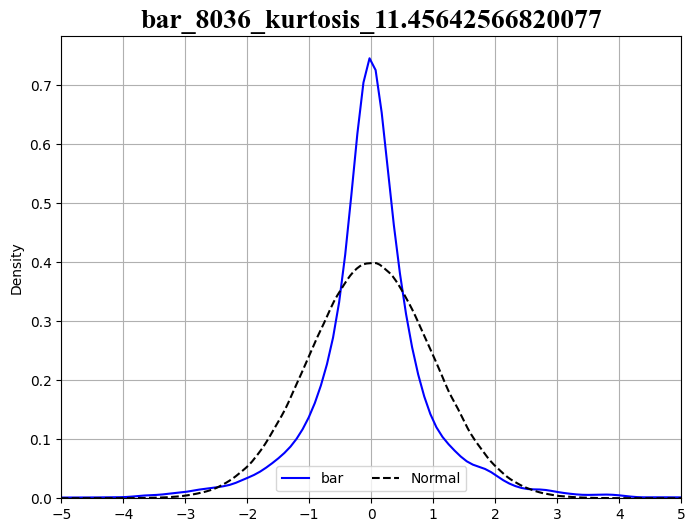

In [6]:
from custom_indicators.utils.plot import plot_kde

plot_kde(merged_bar[:, 2])

In [2]:
from jesse.utils import numpy_candles_to_dataframe
from lightweight_charts import Chart

df_merged_bar = numpy_candles_to_dataframe(merged_bar)

chart = Chart()
chart.set(df_merged_bar[["date", "open", "high", "low", "close", "volume"]])
chart.show(block=True)


RuntimeError: asyncio.run() cannot be called from a running event loop